# Assignment3
## CS-5891-01 Special Topics Deep Learning
## Ronald Picard

In this notebook we will walk through the design, training, and testing of neural networks with one hidden layer. These nueral networks will be used for logistic regression, which is an archaic name for binary classification.

The binary classification will be performed on images of handwritten numerical digits. More specifically, the last numerical digit of my student ID. This digit happens to be 9. Therefore, the goal of our neural network will be to output a the value of 1 when the handwritten numerical digit image input is a 9, and 0 in all other cases.

The data set we will be using is the MNIST data set. This is a very popular data set amoung the machine learning community. The data set contains 60,000 images, and each image contains a handwritten numerical digit. Each of the images have been provided with a truth label that corresponds to the handwritten digit within the image from the set {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. 

For our case, we only care about when the image is 9. Therefore we will need to re-label the truth labels so that all truth labels with the value of 9 are given to the value of 1, and all other truth labels are given the value of 0. 

To start we need to import some needed classes.

In [29]:
import os
import numpy as np
import struct
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pyplot
import csv
import time

First, we must change our path string to the path of our data file containing the features. (Please note that you must change this string to point to the directory with the data file on your machine data file on your machine.) 

Second, we much change the string name of the data files to the names of the MNIST data files. (Please note that you may NOT need to change these. Only change them if your MINST data files are named differently.)

In [30]:
## path
path = 'C:/Users/computer/OneDrive - Vanderbilt/Vanderbilt_Spring_2019/CS_5891_01_SpecialTopicsDeepLearning/Assignment2/'

#Train data
fname_train_images = os.path.join(path, 'train-images.idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels.idx1-ubyte')  # the training set label file path

Next, we retrieve the data from the data files as follows. This imports the data into a feature tensor (3-D matrix) in which each index is a feature matrix corresponding to an image. The label data comes in the form of a vector where each index corresponds to the index of the feature matrix (image) of the feature tensor.  

In [31]:
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows, cols)

print('The training set contains', len(images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', images[0].shape)  # print the shape of the image

The training set contains 60000 images
The shape of the image is (28, 28)


Next, we need to perform both two steps; feature scaling and feature normalization. Feature scaling consists of converting the 28 X 28 image matrices into 784 X 1 feature vectors. In essence we will flatten the images out into vectors so that we can use an input a vector to our single neuron. Feature normalization is a process of normalizing the pixel data to between 0 <= x <= 1 (for logistic regression). Each pixel comes on a scale of 0 <= x <= 255. Since 255 is the maximum for every pixel we shall divide each pixel by that number (elementwise) in order to normalize each pixel to between 0 and 1 (inclusive).

One additional item we need to take care of is relabeling our label (truth) data so that we have a binary classification in which all 9s are converted to 1s and all other labels are converted to 0.

In [32]:
# feature scaling
matrix_side_length = len(images[0])
vector_size = matrix_side_length*matrix_side_length

scaled_images_feature_matrix = []
for image in images:
    reshaped_image = np.array(image).reshape((vector_size))
    scaled_images_feature_matrix.append(reshaped_image)

# convert to numpy array
scaled_images_feature_matrix = np.transpose(np.array(scaled_images_feature_matrix))
print(scaled_images_feature_matrix.shape) # scaled_images_feature_matrix is a matrix of 60000 X 784
#print(scaled_images_feature_matrix[0].shape)

# feature normilization
normilization_factor = 1/255
normalized_scaled_images_feature_matrix = np.multiply(normilization_factor, scaled_images_feature_matrix)
print(normalized_scaled_images_feature_matrix.shape)
#print(normalized_scaled_images_feature_matrix[0])

# re-label for binary classification
value_for_1 = 9
binary_labels = []
for label in labels:
    if(label == 9):
        binary_labels.append(1)
    else:
        binary_labels.append(0)

# convert to numpy array
binary_labels = np.array(binary_labels)
print(len(binary_labels)) # binary_labels is a row vector of 1 X 60000
#print(binary_labels[0])


(784, 60000)
(784, 60000)
60000


In order to test the efficacy of our neural networks, we need to split up the our label data into two data sets; a smaller and a larger one. The larger set will be the training data that we will use to train our neural network on. The smaller set will be the testing data that we will used to test the accuracy of our nueral net. The MNIST data set contains 60,000 images. Therefore, we will use 50,000 images for our training data set, and 10,000 images for our testing data set. 

It is common practice to use a smaller subset of the total data set to debug (ensure it works) and tune hyper-parameters before using the entire time-comsuming data set. This smaller subset is known as a validation set. Therefore, we will first use a validation data set of 600 images. 500 of these images will be used for as our training data set, and the other 100 of these images will be used for our test data set. 

Thus, we will begin by sifting out a validation set from our total data set.

In [60]:
# create a validation data set
size = vector_size

number_of_testing_images = 100
number_of_training_images = 500
number_of_validation_images = number_of_testing_images + number_of_training_images

validation_training_images = []
validation_training_labels = []
validation_testing_images = []
validation_testing_labels = []

factor = 0
for index in range(0, number_of_validation_images):
    if(index <= number_of_training_images - 1):
        validation_training_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        validation_training_labels.append(binary_labels[index + factor])
    else:
        validation_testing_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        validation_testing_labels.append(binary_labels[index + factor])
        
# covert to numpy array
training_images = np.transpose(np.array(validation_training_images))
training_labels = np.array(validation_training_labels)
testing_images = np.transpose(np.array(validation_testing_images))
testing_labels = np.array(validation_testing_labels)

# logger
print(training_images.shape) # validation_training_images is a matrix of 784 X 500
print(training_labels.shape) # validation_testing_labels is a row vector of 1 X 500
print(testing_images.shape) # validation_training_images is a matrix of 784 X 100
print(testing_labels.shape)  # validation_testing_labels is a row vector of 1 X 100

(784, 500)
(500,)
(784, 100)
(100,)


Now we move on to the training of our neural networks with one hidden layer. 

Part 1 - Feed Forword:

For these neural networks we will stick with a simple model 1 hidden layer with between 5-10 units (neurons). This hidden layer will have an input of a matrix (784 X number_of_images) of vectorized images of 784 X 1, and will output a matrix. This matrix will be input to the final layer (second layer). The second layer will only contain 1 unit. It will accept the output matrix from the first layer and will output a row vector of probabilities which we will convert into binary classifications of 0 or 1. (If P(x) >= 0.5 then we will convert it to a 1, otherwise we will convert to 0.) 

The model for the units of the hidden layer will be a vecorized linear model Z^[1] = W^T * X + B, where W is a matrix of 5-10 units (# of units) X 784 of parameter weights, X is the input matrix of vectorized images (784 X # of images), and B is a row vector of bias's. (Note: in this case, b will be scalar that applied in a broadcasing manner to save on memory.) The output of this model Z^[1] will be a matrix (5-10 units X # of images). Z^[1] will be subject to an activation function (we will test sigmoid, relu, tanh). 

We will have three networks to test; each with a different activation function for the hidden layer.

Hidden Layer Activation Functions:

1. The sigmoid activation function is A^[1]  = sigma(Z) = 1/(1 - e^-Z), where Z = Y.

2. The tanh activation function is A^[1]  = tanh(Z) = (e^(2 * Z) - 1)/(e^(2 * Z) + 1)

3. The relu activation function is A^[1]  = relu(Z) =  max(Z, 0).

The model of the output layer will be a vectorized linear model Z^[1] = W * A^[1] + b with a single unit. This linear model will be subjected to a sigmoid activation function.

The resultant row vector will then be used to calculate the cost function values in an elementwise manner. The cost function for this binary classification will be L(Y_Predicted, Y_Label) = -Y_Label * Log(A) - (1-Y_Predicted) * Log(1-A), where Y_Label is the True Label, Y_Predicted is the probability value predicted by the nueral network, and A is the activation function value. The resultant cost row vector will be added up and divided by the number of elements in order to calculate the average cost. 

Part 2 - Back Propogation:

The back propogation technique that we will use for training the neural network, will be gradient descent. This involes utilizing the gradient of the cost function to updated the model parameters in our layers. In order to calculate the gradient we will utilize the chain rule. The goal of back propogation is the adjust the parameter weights and bias's of our model to accurately perform binary classification. In general the chain rule can be used to find the gradient of the cost function (vecorzied rates of change) with respect to the model parameters. The following is the chain that we will utilize. 

dL(A^[2], Y)/dW^[2] = (dl(A^[2], Y)/dz^[2]) * dz^[2]/dW^[2] = (dl(A^[2], Y)/dA^[2] * dA^[2]/dz^[2]) * dz^[2]/dW^[2]

dL(A^[2], Y)/dB^[2] = (dl(A^[2], Y)/dz^[2]) * dz^[2]/dW^[2] = (dl(A^[2], Y)/dA^[2] * dA^[2]/dz^[2]) * dz^[2]/db^[2]

dL(A^[2], Y)/dW^[1] = (dl(A^[2], Y)/dz^[2]) * dZ^[2]/dA^[1] * dA^[1]/dZ^[1] * dz^[1]/dW^[1]

dL(A^[2], Y)/dB^[1] = (dl(A^[2], Y)/dz^[2]) * dZ^[2]/dA^[1] * dA^[1]/dZ^[1] * dz^[1]/dW^[1]



Output Layer - Back Propogation:

The partial derivative of the cost function with respect to the activation function is found by the following:

dL(A^[2], Y)/dA^[2] = -Y/A^[2] + (1-A)/(1-A^[2]).


Due to the chain rule, the derivative of the cost function with respect to the linear model Z is found by the following:

dL(A^[2], y)/dz = dL(A^[2], y)/dA^[2] * dA^[2]/dZ^[2].

The derivative of the sigmoid activation function is da/dz is found by the following:

dA^[2]/dZ^[2] = sigma(Z) = sigma(Z) * (1-sigma(Z))

Therefore, the derivative of the cost function with respect to the output of the linear model is found by the following:

dL(A^[2], y)/dA^[2] * dA^[2]/dZ^[2]. = (-Y/A^[2] + (1-Y)/(1-A^[2])) * (sigma(Z) * (1-sigma(Z))) = A^[2]-Y. (For convienence we will say dZ^[2]  = A^[2]-Y.)

Now we can extrapolate the chain rule to all the paramters of the linear model our first layer.

dL(A^[2], Y)/dW^[2] = dZ^[2] * dZ^[2]/dW^[2] = dZ^[2] * A^[1] = A^[1] * dZ^[2] (we will change our notation to dW^[2] = X * dZ^[2] for convienence)

dL(A^[2], Y)/dB^[2] = dZ^[2] * dZ^[2]/dB^[2] = dZ^[2] (we will change our notation to dW^[2] = dZ^[2] for convienence)



Hidden Layer - Back Propagation:

dL(A^[2], Y)/dA^[1] = dZ^[2] * dZ^[2]/dA^[1] = W^[2] * dz^[2]

dL(A^[2], Y)/dZ^[1] = dL(A^[2], Y)/dA^[1] * dA^[1]/dZ^[1]  = W^[2] * dz^[2] * (element-wise) dA^[1]/dZ^[1] The reason this is element-wise is because we are propgating from a single neuron layer to a hidden layer with multiple neurons (we shall rename this dz^[1] = W^[2] * dz^[2] * (element-wise) dA^[1]/dZ^[1] for conveinience) 

dA^[1]/dZ^[1] depends on the activation function we are using in the hidden layer:

1. The derivative of sigmoid activation function is dA^[1]/dZ^[1]   = sigma(Z) * (1 - sigma(Z)).

2. The derivative of tanh activation function is dA^[1]/dZ^[1]   = 1 - tanh(Z)^2

3. The derivative of relu activation function is dA^[1]/dZ^[1]   = if Z > 0 then 1 else 0.


dL(A^[2], Y)/dW^[1] = dZ^[1] * dZ^[1]/dW^[1] = dZ^[1] * X^T (we will change our notation to dW^[] = dZ^[1] * X^T for convienence)

dL(A^[2], Y)/dB^[1] = dZ^[1] * dZ^[1]/dB^[1] = dZ^[1] (we will change our notation to dB^[1] = dZ^[1] for convienence)


Find vector averages:

m = # number of images

dW_Vec^[2] = 1/m * (X * dZ^[2])

db_Vec^[2] = 1/m * (dZ^[2])

dW_Vec^[1] = 1/m * (dZ^[1] * X^T)

dB_Vec^[1] = 1/m * (dZ^[1])



Finally, we will multiple our gradient transposed parameter row vectors by our learning rate and then subtract this from our parameter vectors.

W^[2]:= W^[2] - alpha * dW_Vec^[2]

b^[2]:= b^[2] - alpha * db_Vec^[2]

W^[1]:= W^[1] - alpha * dW_Vec^[2]

B^[1]:= B^[1] - alpha * dB_Vec^[1]

The first thing we have have to do is initialize our weights and bias's. There are multiple ways to initialize weights and bias's. Typically we will set our values based on either a uniform distribution between ~0.01 and ~0.001, or a normal distribution with a mean between ~0.005 and and standard deviation of ~0.005 (some reasonable standard deviation). There is some flexibility in the initalization of the weights but in general they need to be small (not to small) and varied. The weights need to be different so that the gradients with respect to each other are different. In other words we don't aways want the relative rates of change to be 0. Additionally, we do not want to reach saturation on our output activation function where the gradients are 0 (vanishing gradiants). For this assignment we wills stick with with a uniform random between 0.001 and 0.01. We will also set a random see each time so that we forms our rand values to be the same (or similar if there are more layers).

In [61]:
# initialize weights & bias
lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005

# hidden layer
units = 5
np.random.seed(seed=0)
W_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
B_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1])) # b will be added in a broadcasting manner
#W_1 = np.random.normal(mean, std, [units, size])
#B_1 = np.random.normal(mean, std, [units, 1]) # b will be added in a broadcasting manner

print(W_1.shape) # matrix with a size of # of units X 784
print(B_1.shape) # vector with a size of the # of unit

# output layer
W_2 = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
b_2 = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
#W_2 = np.random.uniform(mean, std, [1, units])
#b_2 = np.random.uniform(mean, std) # b will be added in a broadcasting manner


print(W_2.shape) # vector with a size of # of units
print(b_2) # scalar

(5, 784)
(5, 1)
(1, 5)
0.0040040506440523265


Now we implement our gradient descent algorithm. To decrease lines of code and slightly increase efficienccy we will run the 3 network versions in one loop. Each one will have a different activation function in the hidden layer (i.e. sigmoid, tanh, relu). 

We will also collect data on the accuracy of our networks as a function of training iterations. To do this we will need to find the number of inaccuracate binary classifications (false positives & false negatives). This will be acommplished used our test data set. We will send our test data set through the network and compare the results with the true labels of the test data set. 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: RuntimeWarning: overflow encountered in multiply
C:\Users\computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater_equal



1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081

3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731


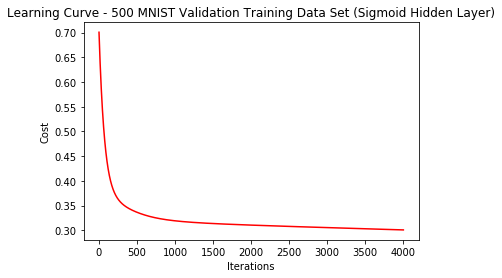

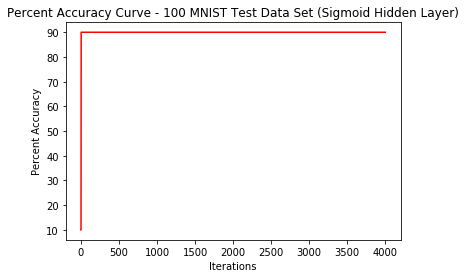

Tanh Activation In the Hidden layer:
Cost: nan
Accuracy: 90.0


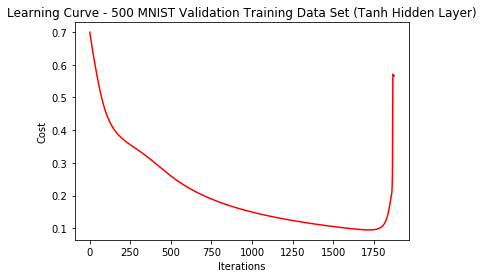

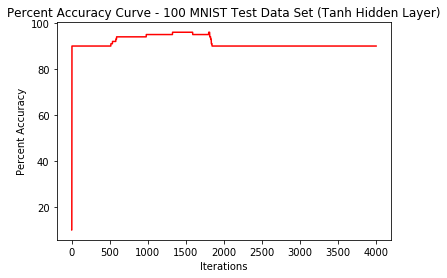

Relu Activation In the Hidden layer:
Cost: 0.07707462061174129
Accuracy: 96.0


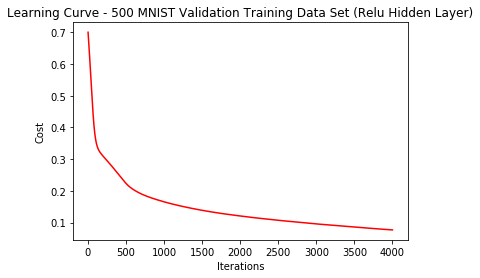

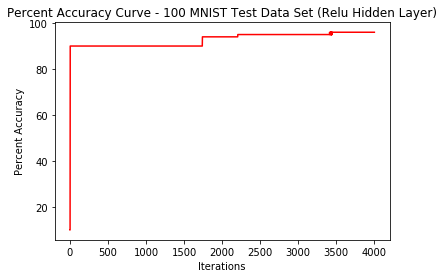

In [62]:
# gradient descent

# make copies of our weights and bias's
W_1_sigmoid = W_1
W_1_tanh = W_1
W_1_relu = W_1

B_1_sigmoid = B_1
B_1_tanh = B_1
B_1_relu = B_1

W_2_sigmoid = W_2
W_2_tanh = W_2
W_2_relu = W_2

b_2_sigmoid = b_2
b_2_tanh = b_2
b_2_relu = b_2

# hyber-parameters
alpha = 0.01;
number_of_iterations = 4000

# data arrays
cost_array_sigmoid = []
cost_array_tanh = []
cost_array_relu = []
accuracy_array_sigmoid = []
accuracy_array_tanh = []
accuracy_array_relu = []
interation_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for iteration in range(1, number_of_iterations + 1):
    
    print(iteration)
    
    # forward propogation training data set
    
    # hidden layer
    Z_1_sigmoid = np.dot(W_1_sigmoid, X) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh = np.dot(W_1_tanh, X) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu = np.dot(W_1_relu, X) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
      
    #print('W1' + str(X.shape)
    #print(B_1.shape)
    #print(W_1_sigmoid.shape)
    #print(Z_1_sigmoid.shape)
    #break
        
    A_1_sigmoid = 1/(1 + np.exp(-Z_1_sigmoid)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh = np.tanh(Z_1_tanh) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu = np.where(Z_1_relu >= 0, Z_1_relu, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid = np.dot(W_2_sigmoid, A_1_sigmoid) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh  = np.dot(W_2_tanh, A_1_tanh) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu = np.dot(W_2_relu, A_1_relu) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid = 1/(1 + np.exp(-Z_2_sigmoid)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh = 1/(1 + np.exp(-Z_2_tanh)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu = 1/(1 + np.exp(-Z_2_relu)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used   
        
    L_sigmoid = np.multiply(-Y, np.log(A_2_sigmoid)) - np.multiply((1 - Y), np.log(1 - A_2_sigmoid)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_tanh = np.multiply(-Y, np.log(A_2_tanh)) - np.multiply((1 - Y), np.log(1 - A_2_tanh)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_relu = np.multiply(-Y, np.log(A_2_relu)) - np.multiply((1 - Y), np.log(1 - A_2_relu)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    
    cost_sigmoid = np.multiply(1/len(L_sigmoid[0]), np.sum(L_sigmoid)) # cost # scalar
    cost_tanh = np.multiply(1/len(L_tanh[0]), np.sum(L_tanh)) # cost # scalar
    cost_relu = np.multiply(1/len(L_relu[0]), np.sum(L_relu)) # cost # scalar
    
    # forward propogation test data set
    
    # hidden layer
    Z_1_sigmoid_test = np.dot(W_1_sigmoid, testing_images) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh_test = np.dot(W_1_tanh, testing_images) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu_test = np.dot(W_1_relu, testing_images) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    
    A_1_sigmoid_test = 1/(1 + np.exp(-Z_1_sigmoid_test)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh_test = np.tanh(Z_1_tanh_test) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu_test = np.where(Z_1_relu_test >= 0, Z_1_relu_test, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid_test = np.dot(W_2_sigmoid, A_1_sigmoid_test) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh_test  = np.dot(W_2_tanh, A_1_tanh_test) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu_test = np.dot(W_2_relu, A_1_relu_test) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid_test = 1/(1 + np.exp(-Z_2_sigmoid_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh_test = 1/(1 + np.exp(-Z_2_tanh_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu_test = 1/(1 + np.exp(-Z_2_relu_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    
    # accuracy
    predicted_array_sigmoid = np.where(A_2_sigmoid_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_tanh = np.where(A_2_tanh_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_relu = np.where(A_2_relu_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    
    accuracy_sigmoid = np.sum(np.absolute(testing_labels - predicted_array_sigmoid)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_tanh = np.sum(np.absolute(testing_labels - predicted_array_tanh)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_relu = np.sum(np.absolute(testing_labels - predicted_array_relu)) # Sum of false positives and false negatives # accuracy is scalar   

    percent_accurate_sigmoid = 100 - np.multiply(100/len(testing_labels), accuracy_sigmoid)
    percent_accurate_tanh = 100 - np.multiply(100/len(testing_labels), accuracy_tanh)
    percent_accurate_relu = 100 - np.multiply(100/len(testing_labels), accuracy_relu)

    # storage for plotting
    cost_array_sigmoid.append(cost_sigmoid)
    cost_array_tanh.append(cost_tanh)
    cost_array_relu.append(cost_relu)
    accuracy_array_sigmoid.append(percent_accurate_sigmoid)
    accuracy_array_tanh.append(percent_accurate_tanh)
    accuracy_array_relu.append(percent_accurate_relu)
    interation_array.append(iteration)
    
    # backpropogation
    
    # hidden layer
    dZ_2_sigmoid = A_2_sigmoid - Y # dZ is 1 X #_of_samples
    dZ_2_tanh = A_2_tanh - Y # dZ is 1 X #_of_samples
    dZ_2_relu = A_2_relu - Y # dZ is 1 X #_of_samples
    
    dW_2_sigmoid = np.multiply(1/len(dZ_2_sigmoid[0]), np.dot(dZ_2_sigmoid, np.transpose(A_1_sigmoid))) # vector
    dW_2_tanh = np.multiply(1/len(dZ_2_tanh[0]), np.dot(dZ_2_tanh, np.transpose(A_1_tanh))) # vector
    dW_2_relu = np.multiply(1/len(dZ_2_relu[0]), np.dot(dZ_2_relu, np.transpose(A_1_relu))) # vector
    
    db_2_sigmoid = np.multiply(1/len(A_2_sigmoid[0]), np.sum(dZ_2_sigmoid)) # scalar
    db_2_tanh = np.multiply(1/len(A_2_tanh[0]), np.sum(dZ_2_tanh)) # scalar
    db_2_relu = np.multiply(1/len(A_2_relu[0]), np.sum(dZ_2_relu)) # scalar
    
    dZ_1_sigmoid = np.multiply(np.dot(np.transpose(W_2_sigmoid), dZ_2_sigmoid), np.multiply(Z_1_sigmoid, (1 - Z_1_sigmoid)))
    dZ_1_tanh = np.multiply(np.dot(np.transpose(W_2_tanh), dZ_2_tanh), 1 - np.multiply(Z_1_tanh, Z_1_tanh))
    dZ_1_relu = np.multiply(np.dot(np.transpose(W_2_relu), dZ_2_relu), np.where(Z_1_relu >= 0, 1, 0))
        
    dW_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.dot(dZ_1_sigmoid, np.transpose(X))) # matrix
    dW_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.dot(dZ_1_tanh, np.transpose(X))) # matrix
    dW_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.dot(dZ_1_relu, np.transpose(X))) # matrix
                  
    dB_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.sum(dZ_1_sigmoid)) # vector
    dB_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.sum(dZ_1_tanh)) # vector
    dB_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.sum(dZ_1_relu)) # vector
    
    # paramter updates
        
    # output layer
    W_2_sigmoid = W_2_sigmoid - np.multiply(alpha, dW_2_sigmoid)
    W_2_tanh = W_2_tanh - np.multiply(alpha, dW_2_tanh)
    W_2_relu = W_2_relu - np.multiply(alpha, dW_2_relu)

    b_2_sigmoid = b_2_sigmoid - np.multiply(alpha, db_2_sigmoid)
    b_2_tanh = b_2_tanh - np.multiply(alpha, db_2_tanh)
    b_2_relu = b_2_relu - np.multiply(alpha, db_2_relu)
                      
    # hidden layer
    W_1_sigmoid = W_1_sigmoid - np.multiply(alpha, dW_1_sigmoid)
    W_1_tanh = W_1_tanh - np.multiply(alpha, dW_1_tanh)
    W_1_relu = W_1_relu - np.multiply(alpha, dW_1_relu)

    B_1_sigmoid = B_1_sigmoid - np.multiply(alpha, dB_1_sigmoid)
    B_1_tanh = B_1_tanh - np.multiply(alpha, dB_1_tanh)
    B_1_relu = B_1_relu - np.multiply(alpha, dB_1_relu)
    
    
    
    

                                 
print('Sigmoid Activation In the Hidden layer:')    
print('Cost: ' + str(cost_sigmoid))    
print('Accuracy: ' + str(percent_accurate_sigmoid))    

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array_sigmoid, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_sigmoid, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()
                   
print('Tanh Activation In the Hidden layer:')    
print('Cost: ' + str(cost_tanh))    
print('Accuracy: ' + str(percent_accurate_tanh))    
    
pyplot.figure()
pyplot.plot(interation_array, cost_array_tanh, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_tanh, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

print('Relu Activation In the Hidden layer:')    
print('Cost: ' + str(cost_relu))    
print('Accuracy: ' + str(percent_accurate_relu))    

pyplot.figure()
pyplot.plot(interation_array, cost_array_relu, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_relu, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

(Note: Please scroll down past the iteration count to see the results. The iteration count was for development to estimate how long the run time would be.)

As shown, our validation set worked, so now we can move on to the full data set, and begin our evaluation and exploration. (please note we will ignore the buffer overflow issue on tanh. That is likely a result of a weight getting exponenially bigger becaue of a limited amount of training data. This is unlikely to happen within the number of iterations we have for our full training data set. Future regularization techniques like L2 & L1 penalization can probably help prevent the issue from occuring; however, those techniques will not be implemented in this assignment.)

First, we need to split up our full data set into testing and training data. We will use 50,000 images as the training data set and 10,000 images as the testing data set. 

In [64]:
# separate the data set
nbr_of_testing_images = 10000
nbr_of_training_images = 50000
nbr_of_images = nbr_of_testing_images + nbr_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

for index in range(0, nbr_of_images):
    if(index <= nbr_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index])        
        training_labels.append(binary_labels[index])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index])        
        testing_labels.append(binary_labels[index])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
print(training_images.shape) # training_images is a matrix of 784 X 50000
print(training_labels.shape) # testing_labels is a row vector of 1 X 50000
print(testing_images.shape) # training_images is a matrix of 784 X 10000
print(testing_labels.shape)  # testing_labels is a row vector of 1 X 10000

(784, 50000)
(50000,)
(784, 10000)
(10000,)


Now we must reset out weights and bias's. We will start with 5 units in the hidden layer. We will also start with a uniform distrubution between 0.01 and 0.001 for the initialization of our weights and bias's. 

In [65]:
# initialize weights & bias
lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005

# hidden layer
units = 5
np.random.seed(seed=0)
W_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
B_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1])) # b will be added in a broadcasting manner
#W_1 = np.random.normal(mean, std, [units, size])
#B_1 = np.random.normal(mean, std, [units, 1]) # b will be added in a broadcasting manner


print(W_1.shape) # matrix with a size of # of units X 784
print(B_1.shape) # vector with a size of the # of unit

# output layer
W_2 = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
b_2 = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
#W_2 = np.random.uniform(mean, std, [1, units])
#b_2 = np.random.uniform(mean, std) # b will be added in a broadcasting manner


print(W_2.shape) # vector with a size of # of units
print(b_2) # scalar

(5, 784)
(5, 1)
(1, 5)
0.0040040506440523265


Now we re-run gradient descent on the full data set. We will run this for 4000 iterations and learning rate of 0.01. This should provide us with a decent convergence on our accuracy and cost, while not taking too long to complete.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


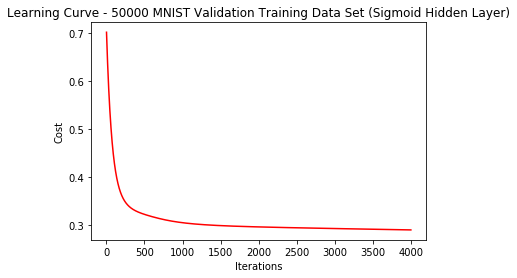

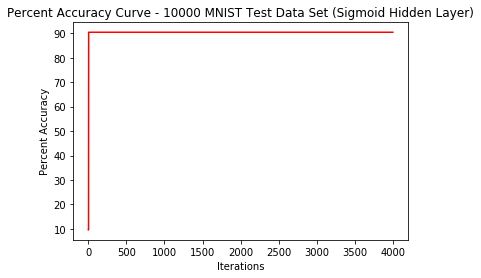

Tanh Activation In the Hidden layer:
Cost: 0.11428120198382749
Accuracy: 96.33


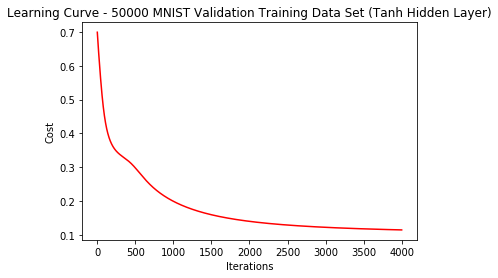

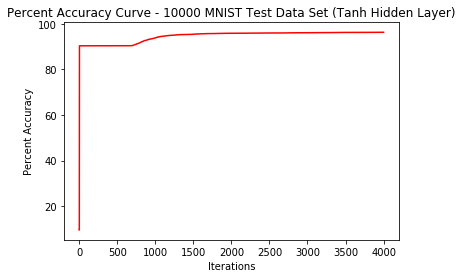

Relu Activation In the Hidden layer:
Cost: 0.1358370041140694
Accuracy: 95.91


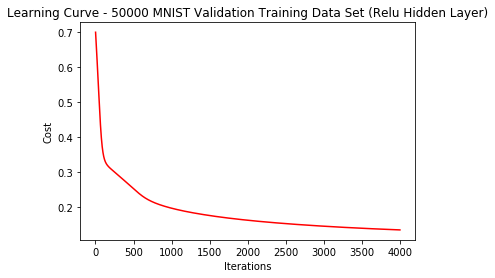

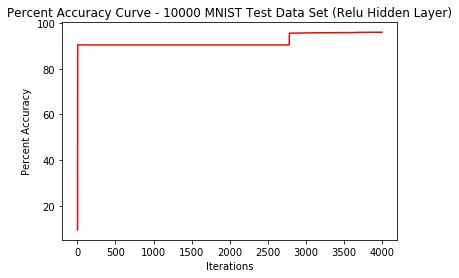

In [66]:
# gradient descent

# make copies of our weights and bias's
W_1_sigmoid = W_1
W_1_tanh = W_1
W_1_relu = W_1

B_1_sigmoid = B_1
B_1_tanh = B_1
B_1_relu = B_1

W_2_sigmoid = W_2
W_2_tanh = W_2
W_2_relu = W_2

b_2_sigmoid = b_2
b_2_tanh = b_2
b_2_relu = b_2

# hyber-parameters
alpha = 0.01;
number_of_iterations = 4000

# data arrays
cost_array_sigmoid = []
cost_array_tanh = []
cost_array_relu = []
accuracy_array_sigmoid = []
accuracy_array_tanh = []
accuracy_array_relu = []
interation_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for iteration in range(1, number_of_iterations + 1):
    
    print(iteration)
        
    # forward propogation training data set
    
    # hidden layer
    Z_1_sigmoid = np.dot(W_1_sigmoid, X) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh = np.dot(W_1_tanh, X) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu = np.dot(W_1_relu, X) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
      
    A_1_sigmoid = 1/(1 + np.exp(-Z_1_sigmoid)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh = np.tanh(Z_1_tanh) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu = np.where(Z_1_relu >= 0, Z_1_relu, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid = np.dot(W_2_sigmoid, A_1_sigmoid) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh  = np.dot(W_2_tanh, A_1_tanh) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu = np.dot(W_2_relu, A_1_relu) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid = 1/(1 + np.exp(-Z_2_sigmoid)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh = 1/(1 + np.exp(-Z_2_tanh)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu = 1/(1 + np.exp(-Z_2_relu)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used   
        
    L_sigmoid = np.multiply(-Y, np.log(A_2_sigmoid)) - np.multiply((1 - Y), np.log(1 - A_2_sigmoid)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_tanh = np.multiply(-Y, np.log(A_2_tanh)) - np.multiply((1 - Y), np.log(1 - A_2_tanh)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_relu = np.multiply(-Y, np.log(A_2_relu)) - np.multiply((1 - Y), np.log(1 - A_2_relu)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 

    cost_sigmoid = np.multiply(1/len(L_sigmoid[0]), np.sum(L_sigmoid)) # cost # scalar
    cost_tanh = np.multiply(1/len(L_tanh[0]), np.sum(L_tanh)) # cost # scalar
    cost_relu = np.multiply(1/len(L_relu[0]), np.sum(L_relu)) # cost # scalar
    
    # forward propogation test data set
    
    # hidden layer
    Z_1_sigmoid_test = np.dot(W_1_sigmoid, testing_images) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh_test = np.dot(W_1_tanh, testing_images) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu_test = np.dot(W_1_relu, testing_images) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    
    A_1_sigmoid_test = 1/(1 + np.exp(-Z_1_sigmoid_test)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh_test = np.tanh(Z_1_tanh_test) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu_test = np.where(Z_1_relu_test >= 0, Z_1_relu_test, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid_test = np.dot(W_2_sigmoid, A_1_sigmoid_test) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh_test  = np.dot(W_2_tanh, A_1_tanh_test) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu_test = np.dot(W_2_relu, A_1_relu_test) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid_test = 1/(1 + np.exp(-Z_2_sigmoid_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh_test = 1/(1 + np.exp(-Z_2_tanh_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu_test = 1/(1 + np.exp(-Z_2_relu_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    
    # accuracy
    predicted_array_sigmoid = np.where(A_2_sigmoid_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_tanh = np.where(A_2_tanh_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_relu = np.where(A_2_relu_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    
    accuracy_sigmoid = np.sum(np.absolute(testing_labels - predicted_array_sigmoid)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_tanh = np.sum(np.absolute(testing_labels - predicted_array_tanh)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_relu = np.sum(np.absolute(testing_labels - predicted_array_relu)) # Sum of false positives and false negatives # accuracy is scalar   

    percent_accurate_sigmoid = 100 - np.multiply(100/len(testing_labels), accuracy_sigmoid)
    percent_accurate_tanh = 100 - np.multiply(100/len(testing_labels), accuracy_tanh)
    percent_accurate_relu = 100 - np.multiply(100/len(testing_labels), accuracy_relu)

    # storage for plotting
    cost_array_sigmoid.append(cost_sigmoid)
    cost_array_tanh.append(cost_tanh)
    cost_array_relu.append(cost_relu)
    accuracy_array_sigmoid.append(percent_accurate_sigmoid)
    accuracy_array_tanh.append(percent_accurate_tanh)
    accuracy_array_relu.append(percent_accurate_relu)
    interation_array.append(iteration)
    
    # backpropogation
    
    # hidden layer
    dZ_2_sigmoid = A_2_sigmoid - Y # dZ is 1 X #_of_samples
    dZ_2_tanh = A_2_tanh - Y # dZ is 1 X #_of_samples
    dZ_2_relu = A_2_relu - Y # dZ is 1 X #_of_samples
    
    dW_2_sigmoid = np.multiply(1/len(dZ_2_sigmoid[0]), np.dot(dZ_2_sigmoid, np.transpose(A_1_sigmoid))) # vector
    dW_2_tanh = np.multiply(1/len(dZ_2_tanh[0]), np.dot(dZ_2_tanh, np.transpose(A_1_tanh))) # vector
    dW_2_relu = np.multiply(1/len(dZ_2_relu[0]), np.dot(dZ_2_relu, np.transpose(A_1_relu))) # vector
    
    db_2_sigmoid = np.multiply(1/len(A_2_sigmoid[0]), np.sum(dZ_2_sigmoid)) # scalar
    db_2_tanh = np.multiply(1/len(A_2_tanh[0]), np.sum(dZ_2_tanh)) # scalar
    db_2_relu = np.multiply(1/len(A_2_relu[0]), np.sum(dZ_2_relu)) # scalar
    
    dZ_1_sigmoid = np.multiply(np.dot(np.transpose(W_2_sigmoid), dZ_2_sigmoid), np.multiply(Z_1_sigmoid, (1 - Z_1_sigmoid)))
    dZ_1_tanh = np.multiply(np.dot(np.transpose(W_2_tanh), dZ_2_tanh), 1 - np.multiply(Z_1_tanh, Z_1_tanh))
    dZ_1_relu = np.multiply(np.dot(np.transpose(W_2_relu), dZ_2_relu), np.where(Z_1_relu >= 0, 1, 0))
        
    dW_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.dot(dZ_1_sigmoid, np.transpose(X))) # matrix
    dW_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.dot(dZ_1_tanh, np.transpose(X))) # matrix
    dW_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.dot(dZ_1_relu, np.transpose(X))) # matrix
                  
    dB_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.sum(dZ_1_sigmoid)) # vector
    dB_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.sum(dZ_1_tanh)) # vector
    dB_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.sum(dZ_1_relu)) # vector
                            
    # paramter updates
        
    # output layer
    W_2_sigmoid = W_2_sigmoid - np.multiply(alpha, dW_2_sigmoid)
    W_2_tanh = W_2_tanh - np.multiply(alpha, dW_2_tanh)
    W_2_relu = W_2_relu - np.multiply(alpha, dW_2_relu)

    b_2_sigmoid = b_2_sigmoid - np.multiply(alpha, db_2_sigmoid)
    b_2_tanh = b_2_tanh - np.multiply(alpha, db_2_tanh)
    b_2_relu = b_2_relu - np.multiply(alpha, db_2_relu)
                      
    # hidden layer
    W_1_sigmoid = W_1_sigmoid - np.multiply(alpha, dW_1_sigmoid)
    W_1_tanh = W_1_tanh - np.multiply(alpha, dW_1_tanh)
    W_1_relu = W_1_relu - np.multiply(alpha, dW_1_relu)

    B_1_sigmoid = B_1_sigmoid - np.multiply(alpha, dB_1_sigmoid)
    B_1_tanh = B_1_tanh - np.multiply(alpha, dB_1_tanh)
    B_1_relu = B_1_relu - np.multiply(alpha, dB_1_relu)


print('Sigmoid Activation In the Hidden layer:')    
print('Cost: ' + str(cost_sigmoid))    
print('Accuracy: ' + str(percent_accurate_sigmoid))    

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array_sigmoid, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_sigmoid, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()
                   
print('Tanh Activation In the Hidden layer:')    
print('Cost: ' + str(cost_tanh))    
print('Accuracy: ' + str(percent_accurate_tanh))    
    
pyplot.figure()
pyplot.plot(interation_array, cost_array_tanh, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_tanh, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

print('Relu Activation In the Hidden layer:')    
print('Cost: ' + str(cost_relu))    
print('Accuracy: ' + str(percent_accurate_relu))    

pyplot.figure()
pyplot.plot(interation_array, cost_array_relu, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_relu, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

(Note: Please scroll down past the iteration count to see the results. The iteration count was for development to estimate how long the run time would be.)

As illustrated, each learning curve begins to flatten out by 4000 iterations; the cost of the network with a hidden layer activation function of sigmoid to 0.2899, the tanh version to 0.11428, and relu version to 0.1358. 

Both the tanh and relu network version developed some nice results after many iterations. They both converge close to 96% accuracy on the test data; which Tanh converging to 96.33% accuracy, and relu converging to 95.91% accuracy.

However, we must note two interesting phenominons when it comes to the version that utilized the sigmoid activation function as the activation function in the hidden layer.

The first phenominon is that the accuracy flattens out rapidly to 90.39% and does not improve anymore, even though the cost continues to decrease. This is approximately 5% less accurate than the previous assigment when we utilized a single neuron. There could be multiple reasons for this so I will name a few. First, for the binary classification case, at a certain point in the training, the micro adjustments to the weights and bias's may no longer be improving or changing the classification of the images, because the adjustments are too small. A second reason could be that the network has not trained enough iterations to truly converge. The third (reasonably likely) reason is that the network began to suffer from a vanishing gradient, which is a common problem with the sigmoid function. The fourth and final reason (also reasonably likely) could be that for this assignment we are not utilizing any specific regularization techiniques such as dropout or parameter variance penalization, therefore this model could be overfitting the training data and performing less well on testing data. As we shall see in this case, we particularlly have a problem with recognizing true positives. The network doesn't want to recognize a positive at all. What can be seen (if you dig into the prediction array) is that every predicted value is zero. This means the network is not recognizing the features of the images with a 9 in the test data. Knowing this, it is clear why the accuracy is ~90%; it is because 9 out of 10 images are not 9s and thus have a true label of 0. We will dig into this phenominon more with examples. This makes the accuracy decieving and the exact cause of the issue difficult to diagnose; though it is likely to be reason three or reason four.

Now we will run through some example classifications in the networks. We will attempt to find one true positive, one true negative, one false positive, and one false negative for each of these networks.


Sigmoid in hindden layer version: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


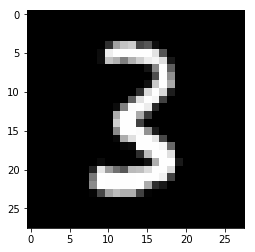

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 3, Size; (1, 28, 28)


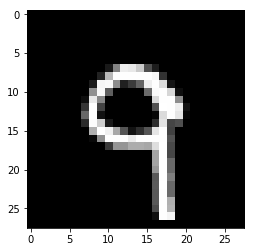


Tanh in hindden layer version: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


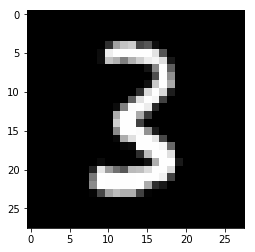

True Postitive Found: True Label: 1 Predicted: 1, @ Test Data Index: 3, Size; (1, 28, 28)


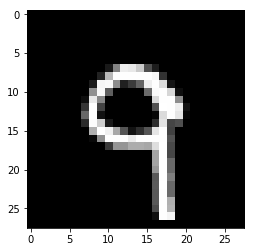

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 78, Size; (1, 28, 28)


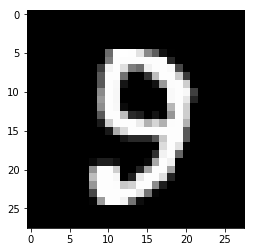

False Positive Found: True Label: 0 Predicted: 1, @ Test Data Index: 369, Size; (1, 28, 28)


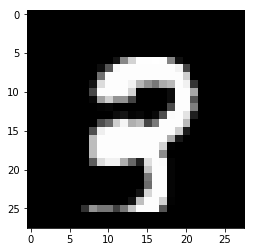


Relu in hindden layer version: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


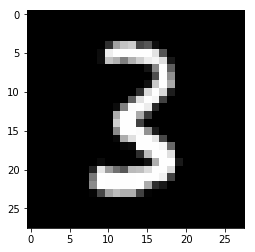

True Postitive Found: True Label: 1 Predicted: 1, @ Test Data Index: 3, Size; (1, 28, 28)


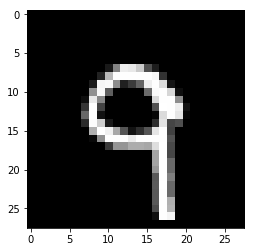

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 20, Size; (1, 28, 28)


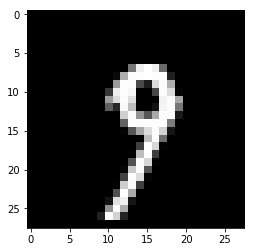

False Positive Found: True Label: 0 Predicted: 1, @ Test Data Index: 369, Size; (1, 28, 28)


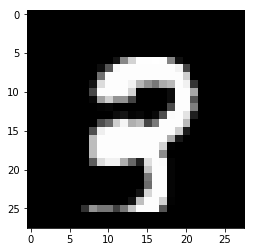

In [67]:
# sigmoid in hindden layer version
print('')
print('Sigmoid in hindden layer version: ')
print('')
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = predicted_array_sigmoid[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()  
        
# tanh in hidden layer version
print('')
print('Tanh in hindden layer version: ')
print('')
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = predicted_array_tanh[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()  
        
# relu in hidden layer version
print('')
print('Relu in hindden layer version: ')
print('')
    
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = predicted_array_relu[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()  

(Please note this whole file must be run in order for these pictures to match the descriptions below.)

As illustrated above, we have attemped to find a true positive, a true negative, a false positive, and a false negative fore each of the three network versions above. We recieved some nice results for the tanh and relu version so we will discuss those first.

We were able to find true negatives and false positives for both of these versions which idicates a healthy network classification and decent generalization (even without a lot of speciallized regularization techniques). 

For the tanh verion we had a false negative of a 9 that was rounded and could have been mistaken as a 0 or 3 (of course this is speculative). We also had a false positive of an image that was actually a sloppy 3, but was partially cut off, so it is understandable for this to be mis-classified.

For the relu version we had a false negative of a 9 that had a strong slant and could have been mistaken as a 7 or a 1 (also speculative). Additionally, the same false positive that tanh experience, relu experience. Again, the sloppy 3 is partially cut off and could have essilly been misclassified as a not a 9. 

As illustrated above, we have attemped to find a true positive, a true negative, a false positive, and a false negative for the network with sigmoid in the hidden layer. However, the issue (probably overfitting or vanishing gradient) hinted at earlier has now revealed itself in a major way. For this version of the network we are able to find a true negative and a false negative, but we are not able to a find a true positive or false positive. The likely reasons for this phenominon occurs is either that the networks has overfit the training data or suffered from a vanishing gradient, and therefore does not detect any 9s at all in the testing data; thus no false positives or true positives are found. 

So far with 5 units in the hidden layer we have decent results. 

In order to compare a network in which the hidden layer has more units, we will use 10 units and re-rerun out gradient descent for the same number of iterations and a similar weight and bias initialization.

First we must re-initialize our weights and bias's as a uniform random distribution with the same random seed as before. 

In [53]:
# initialize weights & bias
lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005

# hidden layer
units = 10
np.random.seed(seed=0)
W_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
B_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1])) # b will be added in a broadcasting manner
#W_1 = np.random.normal(mean, std, [units, size])
#B_1 = np.random.normal(mean, std, [units, 1]) # b will be added in a broadcasting manner


print(W_1.shape) # matrix with a size of # of units X 784
print(B_1.shape) # vector with a size of the # of unit

# output layer
W_2 = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
b_2 = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
#W_2 = np.random.uniform(mean, std, [1, units])
#b_2 = np.random.uniform(mean, std) # b will be added in a broadcasting manner


print(W_2.shape) # vector with a size of # of units
print(b_2) # scalar

(10, 784)
(10, 1)
(1, 10)
0.0035966390735954162


Now we will re-run our gradient descent.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


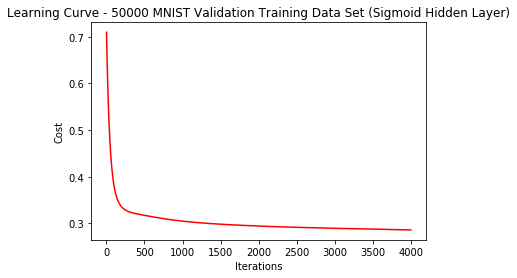

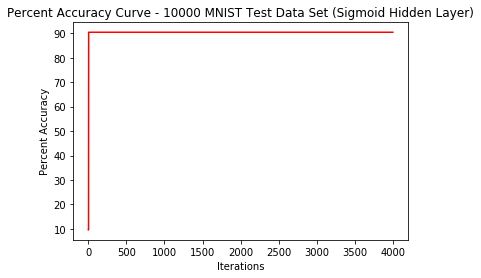

Tanh Activation In the Hidden layer:
Cost: 0.11202854337329606
Accuracy: 96.32


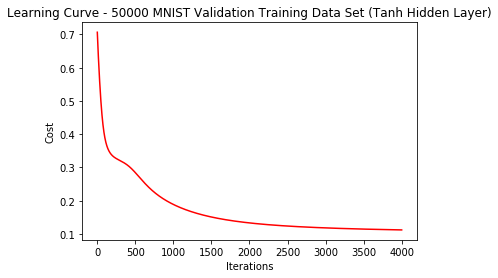

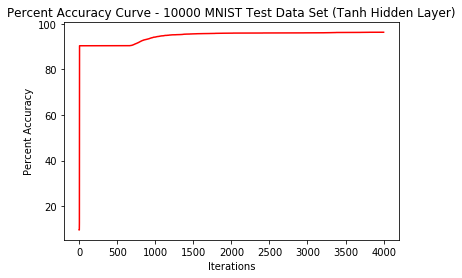

Relu Activation In the Hidden layer:
Cost: 0.1331728485743552
Accuracy: 95.83


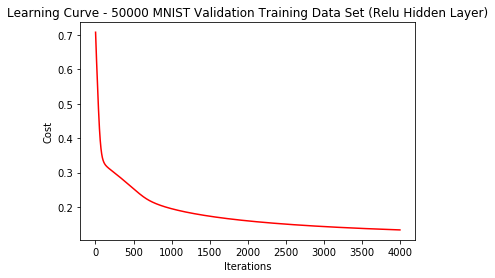

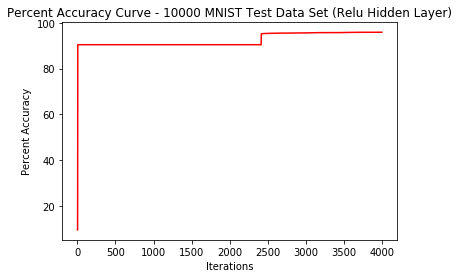

In [54]:
# gradient descent

# make copies of our weights and bias's
W_1_sigmoid = W_1
W_1_tanh = W_1
W_1_relu = W_1

B_1_sigmoid = B_1
B_1_tanh = B_1
B_1_relu = B_1

W_2_sigmoid = W_2
W_2_tanh = W_2
W_2_relu = W_2

b_2_sigmoid = b_2
b_2_tanh = b_2
b_2_relu = b_2

# hyber-parameters
alpha = 0.01;
number_of_iterations = 4000

# data arrays
cost_array_sigmoid = []
cost_array_tanh = []
cost_array_relu = []
accuracy_array_sigmoid = []
accuracy_array_tanh = []
accuracy_array_relu = []
interation_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for iteration in range(1, number_of_iterations + 1):
    
    print(iteration)
        
    # forward propogation training data set
    
    # hidden layer
    Z_1_sigmoid = np.dot(W_1_sigmoid, X) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh = np.dot(W_1_tanh, X) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu = np.dot(W_1_relu, X) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
      
    A_1_sigmoid = 1/(1 + np.exp(-Z_1_sigmoid)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh = np.tanh(Z_1_tanh) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu = np.where(Z_1_relu >= 0, Z_1_relu, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid = np.dot(W_2_sigmoid, A_1_sigmoid) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh  = np.dot(W_2_tanh, A_1_tanh) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu = np.dot(W_2_relu, A_1_relu) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid = 1/(1 + np.exp(-Z_2_sigmoid)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh = 1/(1 + np.exp(-Z_2_tanh)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu = 1/(1 + np.exp(-Z_2_relu)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used   
        
    L_sigmoid = np.multiply(-Y, np.log(A_2_sigmoid)) - np.multiply((1 - Y), np.log(1 - A_2_sigmoid)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_tanh = np.multiply(-Y, np.log(A_2_tanh)) - np.multiply((1 - Y), np.log(1 - A_2_tanh)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_relu = np.multiply(-Y, np.log(A_2_relu)) - np.multiply((1 - Y), np.log(1 - A_2_relu)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 

    cost_sigmoid = np.multiply(1/len(L_sigmoid[0]), np.sum(L_sigmoid)) # cost # scalar
    cost_tanh = np.multiply(1/len(L_tanh[0]), np.sum(L_tanh)) # cost # scalar
    cost_relu = np.multiply(1/len(L_relu[0]), np.sum(L_relu)) # cost # scalar
    
    # forward propogation test data set
    
    # hidden layer
    Z_1_sigmoid_test = np.dot(W_1_sigmoid, testing_images) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh_test = np.dot(W_1_tanh, testing_images) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu_test = np.dot(W_1_relu, testing_images) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    
    A_1_sigmoid_test = 1/(1 + np.exp(-Z_1_sigmoid_test)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh_test = np.tanh(Z_1_tanh_test) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu_test = np.where(Z_1_relu_test >= 0, Z_1_relu_test, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid_test = np.dot(W_2_sigmoid, A_1_sigmoid_test) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh_test  = np.dot(W_2_tanh, A_1_tanh_test) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu_test = np.dot(W_2_relu, A_1_relu_test) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid_test = 1/(1 + np.exp(-Z_2_sigmoid_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh_test = 1/(1 + np.exp(-Z_2_tanh_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu_test = 1/(1 + np.exp(-Z_2_relu_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    
    # accuracy
    predicted_array_sigmoid = np.where(A_2_sigmoid_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_tanh = np.where(A_2_tanh_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_relu = np.where(A_2_relu_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    
    accuracy_sigmoid = np.sum(np.absolute(testing_labels - predicted_array_sigmoid)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_tanh = np.sum(np.absolute(testing_labels - predicted_array_tanh)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_relu = np.sum(np.absolute(testing_labels - predicted_array_relu)) # Sum of false positives and false negatives # accuracy is scalar   

    percent_accurate_sigmoid = 100 - np.multiply(100/len(testing_labels), accuracy_sigmoid)
    percent_accurate_tanh = 100 - np.multiply(100/len(testing_labels), accuracy_tanh)
    percent_accurate_relu = 100 - np.multiply(100/len(testing_labels), accuracy_relu)

    # storage for plotting
    cost_array_sigmoid.append(cost_sigmoid)
    cost_array_tanh.append(cost_tanh)
    cost_array_relu.append(cost_relu)
    accuracy_array_sigmoid.append(percent_accurate_sigmoid)
    accuracy_array_tanh.append(percent_accurate_tanh)
    accuracy_array_relu.append(percent_accurate_relu)
    interation_array.append(iteration)
    
    # backpropogation
    
    # hidden layer
    dZ_2_sigmoid = A_2_sigmoid - Y # dZ is 1 X #_of_samples
    dZ_2_tanh = A_2_tanh - Y # dZ is 1 X #_of_samples
    dZ_2_relu = A_2_relu - Y # dZ is 1 X #_of_samples
    
    dW_2_sigmoid = np.multiply(1/len(dZ_2_sigmoid[0]), np.dot(dZ_2_sigmoid, np.transpose(A_1_sigmoid))) # vector
    dW_2_tanh = np.multiply(1/len(dZ_2_tanh[0]), np.dot(dZ_2_tanh, np.transpose(A_1_tanh))) # vector
    dW_2_relu = np.multiply(1/len(dZ_2_relu[0]), np.dot(dZ_2_relu, np.transpose(A_1_relu))) # vector
    
    db_2_sigmoid = np.multiply(1/len(A_2_sigmoid[0]), np.sum(dZ_2_sigmoid)) # scalar
    db_2_tanh = np.multiply(1/len(A_2_tanh[0]), np.sum(dZ_2_tanh)) # scalar
    db_2_relu = np.multiply(1/len(A_2_relu[0]), np.sum(dZ_2_relu)) # scalar
    
    dZ_1_sigmoid = np.multiply(np.dot(np.transpose(W_2_sigmoid), dZ_2_sigmoid), np.multiply(Z_1_sigmoid, (1 - Z_1_sigmoid)))
    dZ_1_tanh = np.multiply(np.dot(np.transpose(W_2_tanh), dZ_2_tanh), 1 - np.multiply(Z_1_tanh, Z_1_tanh))
    dZ_1_relu = np.multiply(np.dot(np.transpose(W_2_relu), dZ_2_relu), np.where(Z_1_relu >= 0, 1, 0))
        
    dW_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.dot(dZ_1_sigmoid, np.transpose(X))) # matrix
    dW_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.dot(dZ_1_tanh, np.transpose(X))) # matrix
    dW_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.dot(dZ_1_relu, np.transpose(X))) # matrix
                  
    dB_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.sum(dZ_1_sigmoid)) # vector
    dB_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.sum(dZ_1_tanh)) # vector
    dB_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.sum(dZ_1_relu)) # vector
                            
    # paramter updates
        
    # output layer
    W_2_sigmoid = W_2_sigmoid - np.multiply(alpha, dW_2_sigmoid)
    W_2_tanh = W_2_tanh - np.multiply(alpha, dW_2_tanh)
    W_2_relu = W_2_relu - np.multiply(alpha, dW_2_relu)

    b_2_sigmoid = b_2_sigmoid - np.multiply(alpha, db_2_sigmoid)
    b_2_tanh = b_2_tanh - np.multiply(alpha, db_2_tanh)
    b_2_relu = b_2_relu - np.multiply(alpha, db_2_relu)
                      
    # hidden layer
    W_1_sigmoid = W_1_sigmoid - np.multiply(alpha, dW_1_sigmoid)
    W_1_tanh = W_1_tanh - np.multiply(alpha, dW_1_tanh)
    W_1_relu = W_1_relu - np.multiply(alpha, dW_1_relu)

    B_1_sigmoid = B_1_sigmoid - np.multiply(alpha, dB_1_sigmoid)
    B_1_tanh = B_1_tanh - np.multiply(alpha, dB_1_tanh)
    B_1_relu = B_1_relu - np.multiply(alpha, dB_1_relu)


print('Sigmoid Activation In the Hidden layer:')    
print('Cost: ' + str(cost_sigmoid))    
print('Accuracy: ' + str(percent_accurate_sigmoid))    

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array_sigmoid, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_sigmoid, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()
                   
print('Tanh Activation In the Hidden layer:')    
print('Cost: ' + str(cost_tanh))    
print('Accuracy: ' + str(percent_accurate_tanh))    
    
pyplot.figure()
pyplot.plot(interation_array, cost_array_tanh, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_tanh, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

print('Relu Activation In the Hidden layer:')    
print('Cost: ' + str(cost_relu))    
print('Accuracy: ' + str(percent_accurate_relu))    

pyplot.figure()
pyplot.plot(interation_array, cost_array_relu, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_relu, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

(Note: Please scroll down past the iteration count to see the results. The iteration count was for development to estimate how long the run time would be.)

The results for the networks with 10 units are very similar to the results for the networks with 10 units. The sigmoid version still stuffers from the issue it had in the 5 unit version (e.g. vanishing gradients or overfitting). However, both tanh and relu have seen a minor improvment in final accuracy and cost.

Finally, we want to find out how our learning rate affects our accuracy. We need to keep the learning rate small to prevent buffer overflows in Python, therefore we will simply decrease it by an order of magnitude. We will use 5 units in the hidden layer again and set up everything else the same as before. 

First, we re-initialize our weights with 5 units.

In [55]:
# initialize weights & bias
lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005

# hidden layer
units = 5
np.random.seed(seed=0)
W_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
B_1 = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1])) # b will be added in a broadcasting manner
#W_1 = np.random.normal(mean, std, [units, size])
#B_1 = np.random.normal(mean, std, [units, 1]) # b will be added in a broadcasting manner

print(W_1.shape) # matrix with a size of # of units X 784
print(B_1.shape) # vector with a size of the # of unit

# output layer
W_2 = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
b_2 = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
#W_2 = np.random.uniform(mean, std, [1, units])
#b_2 = np.random.uniform(mean, std) # b will be added in a broadcasting manner


print(W_2.shape) # vector with a size of # of units
print(b_2) # scalar

(5, 784)
(5, 1)
(1, 5)
0.0040040506440523265


Now we re-run our gradient descent algorithm.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


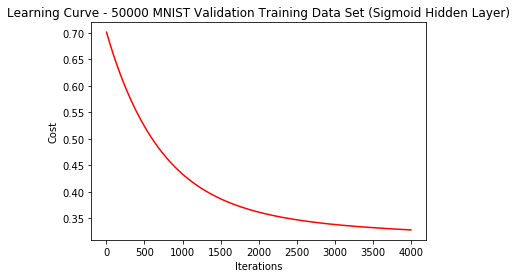

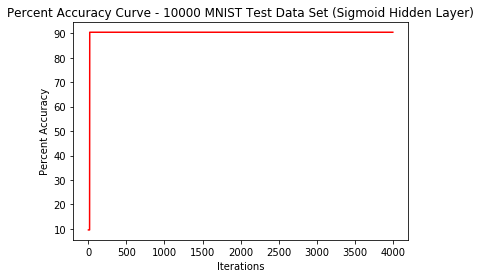

Tanh Activation In the Hidden layer:
Cost: 0.31992292987708154
Accuracy: 90.39


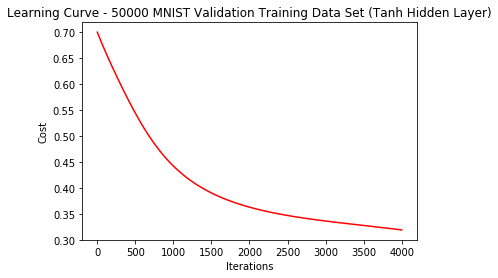

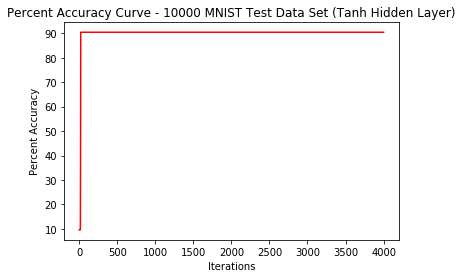

Relu Activation In the Hidden layer:
Cost: 0.27247703908027016
Accuracy: 90.39


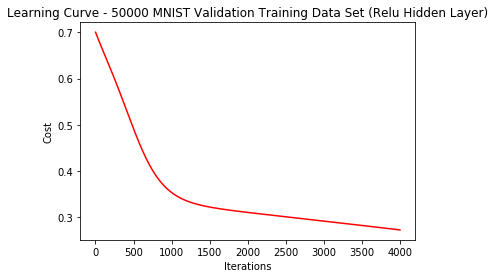

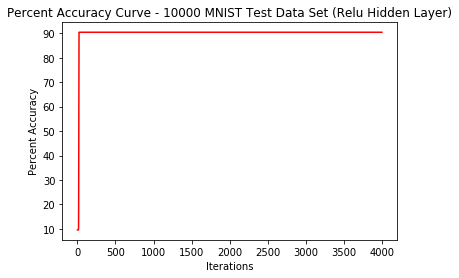

In [56]:
# gradient descent

# make copies of our weights and bias's
W_1_sigmoid = W_1
W_1_tanh = W_1
W_1_relu = W_1

B_1_sigmoid = B_1
B_1_tanh = B_1
B_1_relu = B_1

W_2_sigmoid = W_2
W_2_tanh = W_2
W_2_relu = W_2

b_2_sigmoid = b_2
b_2_tanh = b_2
b_2_relu = b_2

# hyber-parameters
alpha = 0.001;
number_of_iterations = 4000

# data arrays
cost_array_sigmoid = []
cost_array_tanh = []
cost_array_relu = []
accuracy_array_sigmoid = []
accuracy_array_tanh = []
accuracy_array_relu = []
interation_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for iteration in range(1, number_of_iterations + 1):
    
    print(iteration)
        
    # forward propogation training data set
    
    # hidden layer
    Z_1_sigmoid = np.dot(W_1_sigmoid, X) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh = np.dot(W_1_tanh, X) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu = np.dot(W_1_relu, X) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
      
    A_1_sigmoid = 1/(1 + np.exp(-Z_1_sigmoid)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh = np.tanh(Z_1_tanh) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu = np.where(Z_1_relu >= 0, Z_1_relu, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid = np.dot(W_2_sigmoid, A_1_sigmoid) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh  = np.dot(W_2_tanh, A_1_tanh) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu = np.dot(W_2_relu, A_1_relu) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid = 1/(1 + np.exp(-Z_2_sigmoid)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh = 1/(1 + np.exp(-Z_2_tanh)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu = 1/(1 + np.exp(-Z_2_relu)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used   
        
    L_sigmoid = np.multiply(-Y, np.log(A_2_sigmoid)) - np.multiply((1 - Y), np.log(1 - A_2_sigmoid)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_tanh = np.multiply(-Y, np.log(A_2_tanh)) - np.multiply((1 - Y), np.log(1 - A_2_tanh)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 
    L_relu = np.multiply(-Y, np.log(A_2_relu)) - np.multiply((1 - Y), np.log(1 - A_2_relu)) # -Y * log(A) - (1-Y) * log(1-A) # broadcasting is used 

    cost_sigmoid = np.multiply(1/len(L_sigmoid[0]), np.sum(L_sigmoid)) # cost # scalar
    cost_tanh = np.multiply(1/len(L_tanh[0]), np.sum(L_tanh)) # cost # scalar
    cost_relu = np.multiply(1/len(L_relu[0]), np.sum(L_relu)) # cost # scalar
    
    # forward propogation test data set
    
    # hidden layer
    Z_1_sigmoid_test = np.dot(W_1_sigmoid, testing_images) + B_1_sigmoid # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_tanh_test = np.dot(W_1_tanh, testing_images) + B_1_tanh # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    Z_1_relu_test = np.dot(W_1_relu, testing_images) + B_1_relu # Linear Model # Z is #_of_units X #_of_samples # broadcasting is used
    
    A_1_sigmoid_test = 1/(1 + np.exp(-Z_1_sigmoid_test)) # sigmoid(Z) # A is #_of_units X 500 broadcasting is used 
    A_1_tanh_test = np.tanh(Z_1_tanh_test) # tanh(Z) # A is #_of_units X #_of_samples broadcasting is used 
    A_1_relu_test = np.where(Z_1_relu_test >= 0, Z_1_relu_test, 0) # relu(Z) where #_of_units X #_of_samples broadcasting is used
    
    # output layer
    Z_2_sigmoid_test = np.dot(W_2_sigmoid, A_1_sigmoid_test) + b_2_sigmoid # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_tanh_test  = np.dot(W_2_tanh, A_1_tanh_test) + b_2_tanh # Linear Model # Z is 1 X #_of_samples # broadcasting is used
    Z_2_relu_test = np.dot(W_2_relu, A_1_relu_test) + b_2_relu # Linear Model # Z is 1 X #_of_samples # broadcasting is used
        
    A_2_sigmoid_test = 1/(1 + np.exp(-Z_2_sigmoid_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used 
    A_2_tanh_test = 1/(1 + np.exp(-Z_2_tanh_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    A_2_relu_test = 1/(1 + np.exp(-Z_2_relu_test)) # sigmoid(Z) # A is 1 X #_of_samples broadcasting is used  
    
    # accuracy
    predicted_array_sigmoid = np.where(A_2_sigmoid_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_tanh = np.where(A_2_tanh_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    predicted_array_relu = np.where(A_2_relu_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    
    accuracy_sigmoid = np.sum(np.absolute(testing_labels - predicted_array_sigmoid)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_tanh = np.sum(np.absolute(testing_labels - predicted_array_tanh)) # Sum of false positives and false negatives # accuracy is scalar   
    accuracy_relu = np.sum(np.absolute(testing_labels - predicted_array_relu)) # Sum of false positives and false negatives # accuracy is scalar   

    percent_accurate_sigmoid = 100 - np.multiply(100/len(testing_labels), accuracy_sigmoid)
    percent_accurate_tanh = 100 - np.multiply(100/len(testing_labels), accuracy_tanh)
    percent_accurate_relu = 100 - np.multiply(100/len(testing_labels), accuracy_relu)

    # storage for plotting
    cost_array_sigmoid.append(cost_sigmoid)
    cost_array_tanh.append(cost_tanh)
    cost_array_relu.append(cost_relu)
    accuracy_array_sigmoid.append(percent_accurate_sigmoid)
    accuracy_array_tanh.append(percent_accurate_tanh)
    accuracy_array_relu.append(percent_accurate_relu)
    interation_array.append(iteration)
    
    # backpropogation
    
    # hidden layer
    dZ_2_sigmoid = A_2_sigmoid - Y # dZ is 1 X #_of_samples
    dZ_2_tanh = A_2_tanh - Y # dZ is 1 X #_of_samples
    dZ_2_relu = A_2_relu - Y # dZ is 1 X #_of_samples
    
    dW_2_sigmoid = np.multiply(1/len(dZ_2_sigmoid[0]), np.dot(dZ_2_sigmoid, np.transpose(A_1_sigmoid))) # vector
    dW_2_tanh = np.multiply(1/len(dZ_2_tanh[0]), np.dot(dZ_2_tanh, np.transpose(A_1_tanh))) # vector
    dW_2_relu = np.multiply(1/len(dZ_2_relu[0]), np.dot(dZ_2_relu, np.transpose(A_1_relu))) # vector
    
    db_2_sigmoid = np.multiply(1/len(A_2_sigmoid[0]), np.sum(dZ_2_sigmoid)) # scalar
    db_2_tanh = np.multiply(1/len(A_2_tanh[0]), np.sum(dZ_2_tanh)) # scalar
    db_2_relu = np.multiply(1/len(A_2_relu[0]), np.sum(dZ_2_relu)) # scalar
    
    dZ_1_sigmoid = np.multiply(np.dot(np.transpose(W_2_sigmoid), dZ_2_sigmoid), np.multiply(Z_1_sigmoid, (1 - Z_1_sigmoid)))
    dZ_1_tanh = np.multiply(np.dot(np.transpose(W_2_tanh), dZ_2_tanh), 1 - np.multiply(Z_1_tanh, Z_1_tanh))
    dZ_1_relu = np.multiply(np.dot(np.transpose(W_2_relu), dZ_2_relu), np.where(Z_1_relu >= 0, 1, 0))
        
    dW_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.dot(dZ_1_sigmoid, np.transpose(X))) # matrix
    dW_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.dot(dZ_1_tanh, np.transpose(X))) # matrix
    dW_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.dot(dZ_1_relu, np.transpose(X))) # matrix
                  
    dB_1_sigmoid = np.multiply(1/len(dZ_1_sigmoid[0]), np.sum(dZ_1_sigmoid)) # vector
    dB_1_tanh = np.multiply(1/len(dZ_1_tanh[0]), np.sum(dZ_1_tanh)) # vector
    dB_1_relu = np.multiply(1/len(dZ_1_relu[0]), np.sum(dZ_1_relu)) # vector
                            
    # paramter updates
        
    # output layer
    W_2_sigmoid = W_2_sigmoid - np.multiply(alpha, dW_2_sigmoid)
    W_2_tanh = W_2_tanh - np.multiply(alpha, dW_2_tanh)
    W_2_relu = W_2_relu - np.multiply(alpha, dW_2_relu)

    b_2_sigmoid = b_2_sigmoid - np.multiply(alpha, db_2_sigmoid)
    b_2_tanh = b_2_tanh - np.multiply(alpha, db_2_tanh)
    b_2_relu = b_2_relu - np.multiply(alpha, db_2_relu)
                      
    # hidden layer
    W_1_sigmoid = W_1_sigmoid - np.multiply(alpha, dW_1_sigmoid)
    W_1_tanh = W_1_tanh - np.multiply(alpha, dW_1_tanh)
    W_1_relu = W_1_relu - np.multiply(alpha, dW_1_relu)

    B_1_sigmoid = B_1_sigmoid - np.multiply(alpha, dB_1_sigmoid)
    B_1_tanh = B_1_tanh - np.multiply(alpha, dB_1_tanh)
    B_1_relu = B_1_relu - np.multiply(alpha, dB_1_relu)


print('Sigmoid Activation In the Hidden layer:')    
print('Cost: ' + str(cost_sigmoid))    
print('Accuracy: ' + str(percent_accurate_sigmoid))    

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array_sigmoid, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_sigmoid, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Sigmoid Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()
                   
print('Tanh Activation In the Hidden layer:')    
print('Cost: ' + str(cost_tanh))    
print('Accuracy: ' + str(percent_accurate_tanh))    
    
pyplot.figure()
pyplot.plot(interation_array, cost_array_tanh, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_tanh, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

print('Relu Activation In the Hidden layer:')    
print('Cost: ' + str(cost_relu))    
print('Accuracy: ' + str(percent_accurate_relu))    

pyplot.figure()
pyplot.plot(interation_array, cost_array_relu, 'red')
pyplot.title('Learning Curve - ' + str(len(training_images[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array_relu, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(testing_images[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

The results of these networks are what we would intuitively expect. We decrease the learning rate by an order of magnitude but we kept the number of iterations at 4000; therefore, all three of our networks did not have time to converge. It is clear from this that is the learning rate is too small it will take too many iterations (and thus too much time) to converge to a solution. Because our networks did not converge, none of them classified the images of a 9 appropriately and thus were only correct 9/10 times that the testing image was not a 9. 

As we can see from these examples, changing the activation function and learning rate of a neural network with one layer directly affects the results. Additionally, we are able to reach a approximately 96% accuracy when we reach convergence.

This concludes the assignment.